<a href="https://colab.research.google.com/github/Mateusz-best-creator/Learning_ML/blob/main/Book_Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction

## PCA

In [1]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [2]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered.reshape(-1, 3))

# Now we now that inside Vt we have our principal components!
c1 = Vt[0]
c2 = Vt[1]
c1, c2

(array([0.67857588, 0.70073508, 0.22023881]),
 array([-0.72817329,  0.6811147 ,  0.07646185]))

In [3]:
W2 = Vt[:2].T
X_centered.shape, W2.shape

((60, 3), (3, 2))

In [4]:
X2D = X_centered @ W2
X2D[:5]

array([[-0.87323119, -0.29459803],
       [ 0.14888518,  0.51493557],
       [ 1.35121872, -0.39950155],
       [ 0.45436676, -0.1399845 ],
       [-0.73438909, -0.02289346]])

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X2D[:5]

array([[-0.87323119,  0.29459803],
       [ 0.14888518, -0.51493557],
       [ 1.35121872,  0.39950155],
       [ 0.45436676,  0.1399845 ],
       [-0.73438909,  0.02289346]])

In [6]:
print(f"Preserved variance = {np.sum(pca.explained_variance_)}")

Preserved variance = 0.7165401743709277


## Choosing right number of dimensions

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum[:10]

array([0.09704664, 0.16800588, 0.22969677, 0.28359097, 0.33227894,
       0.37540125, 0.40812055, 0.4369595 , 0.4645798 , 0.4881498 ])

In [11]:
n_components = np.argmax(cumsum > 0.95) + 1
print(f"Correct number of components: {n_components}")

Correct number of components: 154


In [12]:
# There is other easier way!
pca = PCA(n_components=0.95) # Preserve 95% of the variance
X_train_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [13]:
X_train_reduced.shape

(60000, 154)

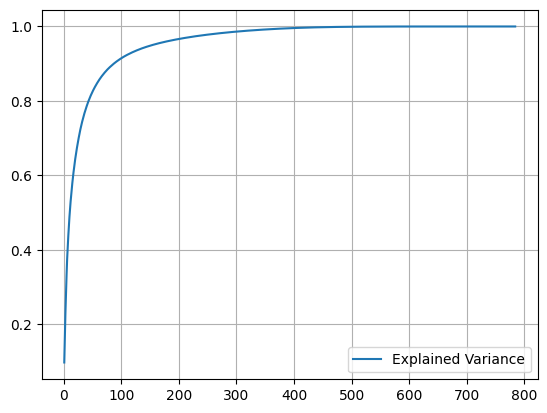

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(cumsum)) + 1, cumsum, label="Explained Variance")
plt.legend()
plt.grid()
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(),
                    RandomForestClassifier())

param_distrib = {"pca__n_components": np.arange(10, 80),
                 "randomforestclassifier__n_estimators": np.arange(50, 500)}
rnd_search = RandomizedSearchCV(estimator=clf,
                                param_distributions=param_distrib,
                                cv=3,
                                n_iter=10,
                                verbose=2)
rnd_search.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END pca__n_components=54, randomforestclassifier__n_estimators=67; total time=   0.6s
[CV] END pca__n_components=54, randomforestclassifier__n_estimators=67; total time=   0.6s
[CV] END pca__n_components=54, randomforestclassifier__n_estimators=67; total time=   0.5s
[CV] END pca__n_components=57, randomforestclassifier__n_estimators=280; total time=   1.7s
[CV] END pca__n_components=57, randomforestclassifier__n_estimators=280; total time=   2.3s
[CV] END pca__n_components=57, randomforestclassifier__n_estimators=280; total time=   1.5s
[CV] END pca__n_components=63, randomforestclassifier__n_estimators=74; total time=   0.6s
[CV] END pca__n_components=63, randomforestclassifier__n_estimators=74; total time=   0.6s
[CV] END pca__n_components=63, randomforestclassifier__n_estimators=74; total time=   0.6s
[CV] END pca__n_components=48, randomforestclassifier__n_estimators=469; total time=   2.2s
[CV] END pca__n_component

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   verbose=2)

In [19]:
# Lets look at the hyperparameters
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 492, 'pca__n_components': 38}

## Incremental PCA

Useful when we cannot fit entire dataset once in memory.

In [21]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

inc_pca.explained_variance_ratio_[:10]

array([0.09704663, 0.07095923, 0.06169087, 0.05389418, 0.04868795,
       0.04312229, 0.03271927, 0.02883891, 0.02762025, 0.02356995])

## Random Projection

In [22]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, e = 5000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=e)
d

7300

In [28]:
n = 20000
P = np.random.randn(d, n)
X = np.random.randn(m, n)
X_reduced = X @ P.T
X_reduced.shape

(5000, 7300)

In [29]:
# Using sklearn
from sklearn.random_projection import GaussianRandomProjection

g = GaussianRandomProjection(eps=e)
X_reduced = g.fit_transform(X)
X_reduced.shape

(5000, 7300)

# Exercises

## Exercise 9

In [31]:
import time
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

rf_clf = RandomForestClassifier()
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
print(end - start)
rf_clf.score(X_test, y_test)

52.42928099632263


0.9691

In [32]:
rf_pca_clf = make_pipeline(PCA(n_components=0.95),
                           RandomForestClassifier())
start = time.time()
rf_pca_clf.fit(X_train, y_train)
end = time.time()
print(end - start)
rf_pca_clf.score(X_test, y_test)

150.27666807174683


0.9494

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf_pca = make_pipeline(PCA(n_components=0.95),
                            SGDClassifier())
start1 = time.time()
sgd_clf.fit(X_train, y_train)
end1 = time.time()
print(f"SGD time without PCA = {end1 - start1}")
print(f"SGD1 score = {sgd_clf.score(X_test, y_test)}\n\n")

start2 = time.time()
sgd_clf_pca.fit(X_train, y_train)
end2 = time.time()
print(f"SGD time with PCA = {end2 - start2}")
print(f"SGD2 score = {sgd_clf_pca.score(X_test, y_test)}\n\n")

SGD time without PCA = 210.06445240974426
SGD1 score = 0.8774


SGD time with PCA = 58.923649072647095
SGD2 score = 0.8881




## Exercise 10

In [35]:
from sklearn.manifold import TSNE

X_train_5000 = X_train[:5000]
tsne = TSNE(n_components=2)
X_train_5000_reduced = tsne.fit_transform(X_train_5000)
X_train_5000_reduced.shape

(5000, 2)

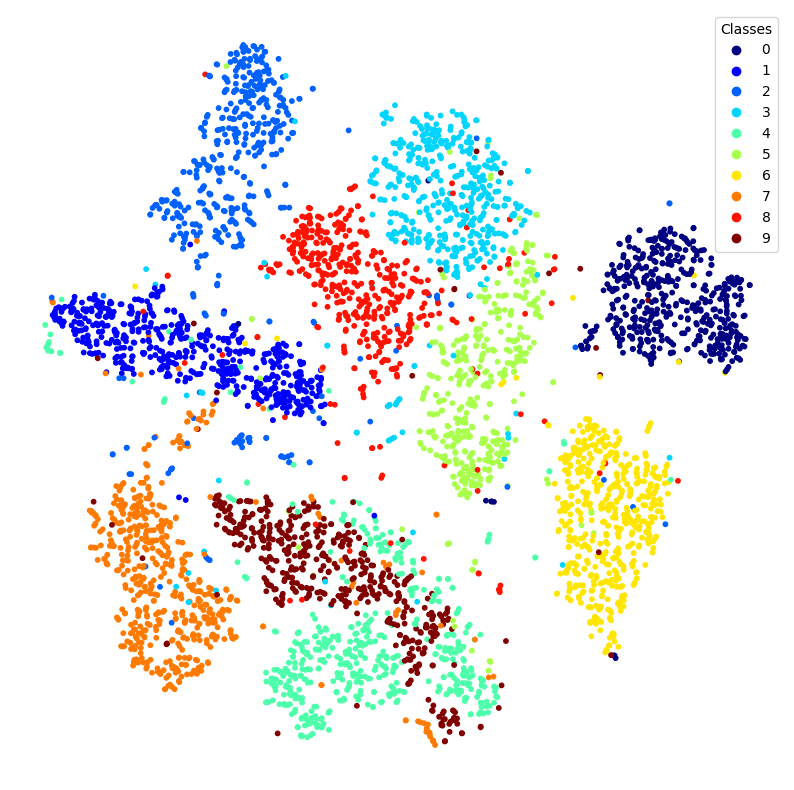

In [45]:
y_train_5000 = y_train[:5000]

y_train_5000_int = np.array(y_train_5000, dtype=int)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_train_5000_reduced[:, 0], X_train_5000_reduced[:, 1], c=y_train_5000_int, s=10, cmap='jet')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.axis("off")
plt.show()


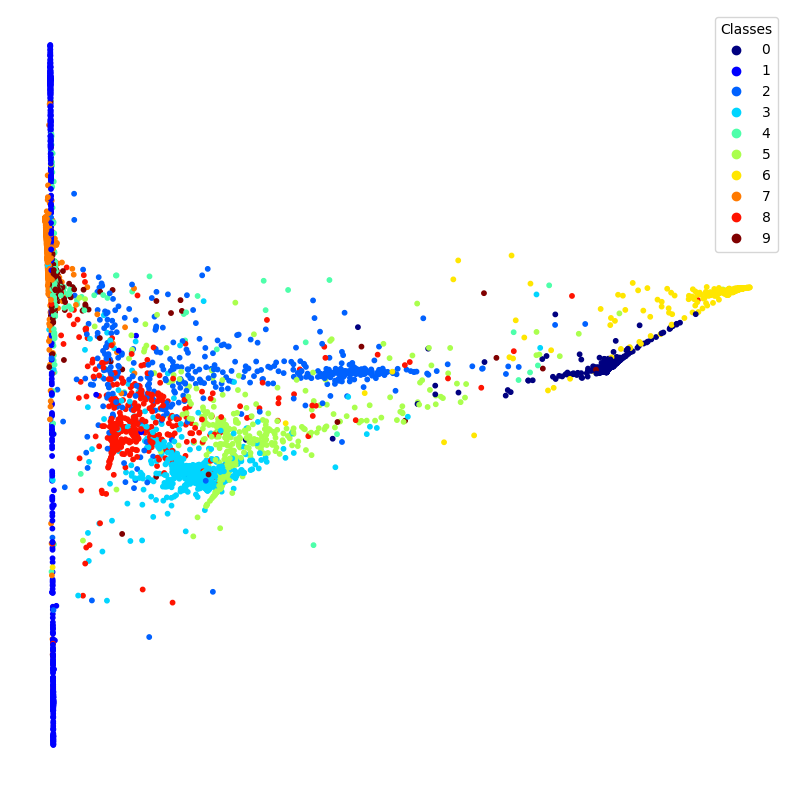

In [46]:
# Let's try local linear embedding which works best with rolled datasets
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_lle_reduced = lle.fit_transform(X_train_5000)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(X_lle_reduced[:, 0], X_lle_reduced[:, 1], c=y_train_5000_int, s=10, cmap='jet')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.axis("off")
plt.show()